### Some work on the scFv data and Dataset
### The scFv antibody sequence/binding affinity data from a-alpha-Bio's Nature Communications paper
quantitative binding scores of scFv-format antibodies against a SARS-CoV-2 target peptide collected via an AlphaSeq assay

#### Two datasets:
* antibody_dataset_1 : 1109000 MITLL_AAlphaBio_Ab_Binding_dataset.csv rows
* antibody_dataset_2 : 1903928 MITLL_AAlphaBio_Ab_Binding_dataset2.csv rows



--------
#### Affinities
* reported values are log10(Kd(nM))

* delG = RT log10(Kd)    # or -RT log10(Ka)
* R = 0.008314 kJ mol-1 (1.98722 cal/K•mol)
* T = 298.15 room temp
* if Kd = 1.909nM, then delG = -5.16 kcal/mol binding free energy
* "Data include antibodies with predicted affinity measurements ranging from 37 pM to 22 mM"
   * 37pm corresponds to delG = -6.18 kcal/mol binding free energy.
   * 22mM corresponds to delG = -0.98 kcal/mol binding free energy.
* For reference, the biotin/avidin binding free energy is one of the strongest in nature with absolute free energy of binding, −20.4 kcal/mol
--------

In [1]:
%load_ext autoreload

In [2]:
%autoreload
# import libraries
import numpy as np
import pickle as pk
import pandas as pd
import math
# pd.options.mode.copy_on_write = True # to avoid SettingWithCopyWarning
import os
import yaml
import sys
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from pytorch_lightning.core import LightningModule
import pytorch_lightning as pl
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


%matplotlib inline

/home/mark/anaconda3/envs/avm-dvm/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/mark/anaconda3/envs/avm-dvm/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
#
# Read the config
#
config_path = './config/fine_tune_config.yaml'  
with open(config_path, 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

config = config['model_params']
print(config)

{'n_embd': 512, 'regress_head_drop': 0.1, 'vocab_size': 23, 'block_size': 91, 'mask_prob': 0.0, 'weight_decay': 0.1, 'learning_rate': 0.0001, 'lr_gamma': 0.9985, 'betas': [0.9, 0.95], 'accelerator': 'gpu', 'devices': 2, 'batch_size': 1024, 'num_workers': 20, 'grad_norm_clip': 1.0, 'num_epochs': 100, 'checkpoint_every_n_train_steps': 100, 'save_top_k': 1, 'monitor': 'loss', 'mode': 'min', 'log_dir': './lightning_logs/', 'log_every_nsteps': 100, 'checkpoint_pretrained': '/home/mark/dev/myBERT/lightning_logs/pre-train/checkpoints/epoch=4-step=252700.ckpt', 'checkpoint_name': 'None', 'seed': 3407}


In [4]:
import torch
from torch.utils.data import Dataset
import pandas as pd

#--------------------------------------------------------
# Code fragments taken from:
# * https://github.com/barneyhill/minBERT
# * https://github.com/karpathy/minGPT

# protein sequence data taken from:
# * https://www.nature.com/articles/s41467-023-39022-2
# * https://zenodo.org/records/7783546
#--------------------------------------------------------

class scFv_Dataset(Dataset):
    """
    Emits batches of amino acid sequences and binding energies
    """
    def __init__(self, config, csv_file_path, skiprows=0):  
        super().__init__()
        self.config = config
        print('reading the data from:', csv_file_path)
        self.df = pd.read_csv(csv_file_path, skiprows=skiprows)
        
        # 20 naturally occuring amino acids in human proteins plus MASK token, 
        # 'X' is a special token for unknown amino acids, and CLS token is for classification
        self.chars = ['CLS', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'X', '[MASK]']
        print('vocabulary:', self.chars)

        data_size, vocab_size = self.df.shape[0], len(self.chars)
        print('data has %d rows, %d vocab size (unique).' % (data_size, vocab_size))

        self.stoi = { ch:i for i,ch in enumerate(self.chars) }
        self.itos = { i:ch for i,ch in enumerate(self.chars) }
        self.vocab_size = vocab_size

    def get_vocab_size(self):
        return self.vocab_size

    def get_block_size(self):
        return self.config['block_size']

    def __len__(self):
        return self.df.shape[0] #len(self.data) - self.config['block_size']

    """ Returns data, mask pairs used for Masked Language Model training """
    def __getitem__(self, idx):
        seq = self.df.loc[idx, 'Sequence']
        affinity = self.df.loc[idx, 'Pred_affinity']
        assert not math.isnan(affinity), 'affinity is nan'
        assert affinity >= 0.0, 'affinity is negative'
        assert len(seq) >= self.config['block_size'], 'sequence is too short'

        # get a randomly located block_size-1 substring from the sequence
        # '-1' so we can prepend the CLS token to the start of the encoded string
        if len(seq) == self.config['block_size']-1:
            chunk = seq
        else:
            start_idx = np.random.randint(0, len(seq) - (self.config['block_size'] - 1))
            chunk = seq[start_idx:start_idx + self.config['block_size']-1]

        # encode every character to an integer
        dix = torch.tensor([self.stoi[s] for s in chunk], dtype=torch.long)

        # prepend the CLS token to the sequence
        dix = torch.cat((torch.tensor([self.stoi['CLS']], dtype=torch.long), dix))

        mask = None
        if self.config['mask_prob'] > 0:
            # get number of tokens to mask
            n_pred = max(1, int(round(self.config['block_size']*self.config['mask_prob'])))

            # indices of the tokens that will be masked (a random selection of n_pred of the tokens)
            masked_idx = torch.randperm(self.config['block_size']-1, dtype=torch.long, )[:n_pred]
            masked_idx += 1  # so we never mask the CLS token

            mask = torch.zeros_like(dix)

            # copy the actual tokens to the mask
            mask[masked_idx] = dix[masked_idx]
            
            # ... and overwrite them with MASK token in the data
            dix[masked_idx] = self.stoi["[MASK]"]

        # print('dix shape:', dix.shape, ', affinity:', affinity)
        # print('dix type:', dix.dtype, ', affinity type:', type(affinity))
        return dix, affinity 


In [ ]:
test_path = './data/mit-ll/mit-ll-AlphaSeq_Antibody_Dataset-a8f64a9/antibody_dataset_1/test_set.csv'
train_path = './data/mit-ll/mit-ll-AlphaSeq_Antibody_Dataset-a8f64a9/antibody_dataset_1/train_set.csv'
dataset = scFv_Dataset(config, test_path)

In [ ]:
print(dataset.__len__())
dix, affinity = dataset.__getitem__(0)
print(dix[:10])
print(affinity)


In [ ]:
train_loader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=False)
data_iter = iter(train_loader)

batch = next(data_iter)
dix, affinity = batch
print(dix.shape)

-----------------------------
## antibody_dataset_1
### The scFv antibody sequence/binding affinity data in the AlphaSeq experimental assay data

#### Some observations:
* total rows: 1109000

* Number of unique sequences based on actual sequence: 104968
* Number of unique sequences using the POI sequence label: 104972
* There are between 8-20 instances of each sequence
* Number of rows where affinity is not NAN : 340100  (most of original set have nan affinities!??)
    * number of unique sequences in this subset: 87211
    
    * number of unique POIs in this subset: 87215
    * for each of these unique sequences, there are multiple binding affinity values
         * seq_dict: first entry
         
         *  seq 1 : , num affinity values: 6 , values: {0.8661294738454064, 0.9084780753465632, 0.9577932321017446, 3.9196288144788087, .....}
         *  -RTlog10(3.9) = -4.98 kcal/mol binding free energy
         *  -RTlog10(0.866) = -5.36 kcal/mol
         *  for reference kT = 0.6 kcal/mol so this difference is on the order of kT
    * use the mean value for affinity (or median)?


#### The paper:
*  https://www.nature.com/articles/s41597-022-01779-4#Tab4 lists 71384 
* "Of the 119,600 designs, 104,972 were successfully built in to the AlphaSeq library and target binding was subsequently measured with 71,384 designs"
    

In [ ]:
# calc binding free energy (in kcal/mol) from Kd 
# affinity is Kd in nM
R = 1.98722 # cal/(mol*K)
T = 298.15 # K
def free_energy(Kd):
    delG = R * T * math.log10(Kd * 1e-9)    # or -RT log10(Ka)
    return delG/1000

In [ ]:
free_energy(0.005687)

In [5]:
# The experimental data from AlphaSeq Nature study.
data_path = './data/mit-ll/mit-ll-AlphaSeq_Antibody_Dataset-a8f64a9/antibody_dataset_1/MITLL_AAlphaBio_Ab_Binding_dataset.csv'
df = pd.read_csv(data_path)
print(df.shape)
print(df.columns)

(1109000, 14)
Index(['POI', 'Sequence', 'Target', 'Assay', 'Replicate', 'Pred_affinity',
       'HC', 'LC', 'CDRH1', 'CDRH2', 'CDRH3', 'CDRL1', 'CDRL2', 'CDRL3'],
      dtype='object')


In [14]:
df['Sequence'].describe()


count                                               1109000
unique                                               104968
top       EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...
freq                                                     44
Name: Sequence, dtype: object

In [7]:
# Check on distribution of sequence lengths
# loop through the rows using iterrows()
def get_misc_info(df):
    seq_lens = []
    seq_set = set()
    poi_dict = {}
    for index, row in df.iterrows():
        seq = row['Sequence']
        poi = row['POI']
        seq_lens.append(len(seq))
        seq_set.add(seq)
        if poi not in poi_dict:
            poi_dict[poi] = 1
        else:
            poi_dict[poi] += 1

    print('number of unique sequences:', len(seq_set))
    print('number of unique POIs:', len(poi_dict))

    counts = list(poi_dict.values())
    counts.sort()
    print('min count:', counts[0], ', max count:', counts[-1])

In [8]:
# The entire antibody_dataset_1 csv file.
get_misc_info(df)

# results:
# number of unique sequences: 104968
# number of unique POIs: 104972
# min count: 8 , max count: 20
#
# Note: 104,972 agrees with the number listed in the Nature paper.

number of unique sequences: 104968
number of unique POIs: 104972
min count: 8 , max count: 20


In [9]:
# The entire antibody_dataset_1 csv file.
print('starting shape:', df.shape)

# Drop NANs in pred affinity column
df_clean = df.dropna(subset=['Pred_affinity'])
print(df_clean.shape)
print('after removing nans:', df_clean.shape)
get_misc_info(df_clean)

# starting shape: (1109000, 14)
# (340100, 14)
# after removing nans: (340100, 14)
# number of unique sequences: 87211
# number of unique POIs: 87215
# min count: 1 , max count: 12

starting shape: (1109000, 14)
(340100, 14)
after removing nans: (340100, 14)
number of unique sequences: 87211
number of unique POIs: 87215
min count: 1 , max count: 12


In [10]:
# Examine the values for affinity for each repeat of each sequence.
seq_lens = []
seq_set = set()
seq_dict = {} # will contain a set for binding energies for each unique sequence
poi_dict = {} # will contain a set for binding energies for each unique POI
for index, row in df_clean.iterrows():
    seq = row['Sequence']
    poi = row['POI']
    affinity = row['Pred_affinity']
    if seq not in seq_dict:
        seq_dict[seq] = set()
        seq_dict[seq].add(affinity)
    else:
        seq_dict[seq].add(affinity)

    if poi not in poi_dict:
        poi_dict[poi] = set()
        poi_dict[poi].add(affinity)
    else:
        poi_dict[poi].add(affinity)

print('len seq_dict:', len(seq_dict))
print('len poi_dict:', len(seq_dict))

print('seq_dict: first few entries')
for i, (k, v) in enumerate(seq_dict.items()):
    assert len(v) > 0, 'empty set for sequence'
    print(i, ':', ', num values:', len(v), ', values:', v)

    if i > 5:
        break


print('poi_dict: first few entries')
for i, (k, v) in enumerate(poi_dict.items()):
    assert len(v) > 0, 'empty set for POI'
    print(i, ':', ', num values:', len(v), ', values:', v)

    if i > 5:
        break


len seq_dict: 87211
len poi_dict: 87211
seq_dict: first few entries
0 : , num values: 6 , values: {0.8661294738454064, 0.9084780753465632, 0.9577932321017446, 3.9196288144788087, 4.914154179746138, 5.723329881345849}
1 : , num values: 12 , values: {1.4505434853677084, 1.4248811789665847, 3.736022319355234, 4.208875709332999, 4.1969741379377705, 5.053950729480507, 4.690954801766403, 4.225537246160031, 1.5815625508664832, 4.28826022838054, 4.9744274864843865, 5.007441109453564}
2 : , num values: 7 , values: {1.7899955194100752, 2.263831676684976, 3.8100026599168384, 1.7935568167187643, 5.380368626969683, 3.908238706063365, 3.955892163776589}
3 : , num values: 7 , values: {1.7042172390142856, 1.7621526510488703, 1.825962828947824, 4.417285434453146, 4.549318549448136, 4.78409345871224, 5.106323925284952}
4 : , num values: 8 , values: {1.6254710084772963, 1.6099233031912252, 3.4684917740243204, 4.330292501814343, 1.68272713929683, 3.524101524593373, 4.714744238136452, 3.723603473569288}
5 

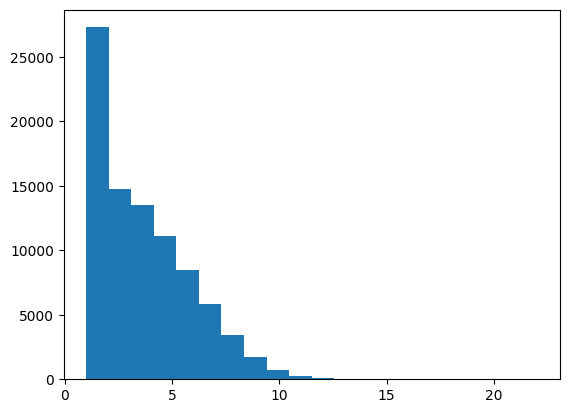

number of sequences with just 1 binding affinity value: 27299


In [11]:
# Histogram of the number of binding affinity values for the unique sequences (that have binding affinities != NAN)
#
lengths = [len(v) for k,v in seq_dict.items()]
lengths.sort()
blah = plt.hist(lengths, bins=20)
plt.show()

print('number of sequences with just 1 binding affinity value:', int(blah[0][0]))

-----
## Final training set:
* 87211 sequences
* affinity will be the mean of each sequence’s multiple affinities


In [12]:
print('len seq_dict:', len(seq_dict))
print('seq_dict: first few entries')
for i, (k, v) in enumerate(seq_dict.items()):
    assert len(v) > 0, 'empty set for sequence'
    print(i, ':', ', num values:', len(v), ', values:', v)
    if i > 2:
        break

print()
# calc the mean of the binding affinities for each sequence
seq_mean_dict = {}
for k,v in seq_dict.items():
    seq_mean_dict[k] = np.mean(list(v))

# print the first few entries
for i, (k, v) in enumerate(seq_mean_dict.items()):
    print(i, ':', k[:20], ', mean:', v)
    if i > 2:
        break    

lengths = [len(k) for k,v in seq_mean_dict.items()]
lengths.sort()
print('min length:', lengths[0], ', max length:', lengths[-1])

seqs = [k for k,v in seq_mean_dict.items()]
s1 = seqs[45]
s2 = seqs[2000]
diff = [i for i in range(len(s1)) if s1[i] != s2[i]]
print(diff)


len seq_dict: 87211
seq_dict: first few entries
0 : , num values: 6 , values: {0.8661294738454064, 0.9084780753465632, 0.9577932321017446, 3.9196288144788087, 4.914154179746138, 5.723329881345849}
1 : , num values: 12 , values: {1.4505434853677084, 1.4248811789665847, 3.736022319355234, 4.208875709332999, 4.1969741379377705, 5.053950729480507, 4.690954801766403, 4.225537246160031, 1.5815625508664832, 4.28826022838054, 4.9744274864843865, 5.007441109453564}
2 : , num values: 7 , values: {1.7899955194100752, 2.263831676684976, 3.8100026599168384, 1.7935568167187643, 5.380368626969683, 3.908238706063365, 3.955892163776589}
3 : , num values: 7 , values: {1.7042172390142856, 1.7621526510488703, 1.825962828947824, 4.417285434453146, 4.549318549448136, 4.78409345871224, 5.106323925284952}

0 : EVQLVETGGGLVQPGGSLRL , mean: 2.8815856094774186
1 : EVQLVETGGGLVQPGGSLRL , mean: 3.736619248629351
2 : EVQLVETGGGLVQPGGSLRL , mean: 3.2716980242200413
3 : EVQLVETGGGLVQPGGSLRL , mean: 3.4499077267013507

In [ ]:
# Create the train and test sets and save as csv files
seqs = [k for k,v in seq_mean_dict.items()]
affinities = [v for k,v in seq_mean_dict.items()]

df = pd.DataFrame({'Sequence': seqs, 'Pred_affinity': affinities})

# Remove enries with negative affinity values
df_clean = df[df['Pred_affinity'] > 0]
print(df_clean.describe())

# Train/test split 90/10
# train_df = df_clean.sample(frac=0.9, random_state=42)
# test_df = df_clean.drop(train_df.index)
# print('train:', train_df.shape, ', test:', test_df.shape)

# save to csv
# train_df.to_csv('./data/mit-ll/mit-ll-AlphaSeq_Antibody_Dataset-a8f64a9/antibody_dataset_1/train_set.csv', index=False)
# test_df.to_csv('./data/mit-ll/mit-ll-AlphaSeq_Antibody_Dataset-a8f64a9/antibody_dataset_1/test_set.csv', index=False)



In [18]:
a = torch.zeros(4)
print(a.shape)
print(len(a))

torch.Size([4])
4


#### Remove all rows that contain NAN in the Pred_affinity column.
Yikes!  ~75% of the dataframe has NANs in this column.

In [ ]:
df['Pred_affinity'].isna().sum()

aff = df['Pred_affinity']
# c = c[~np.isnan(c)]
for i, a in enumerate(aff):
    if np.isnan(a):
        print(i, a)
        break

print(df.loc[23925])  #, 'Pred_affinity'])

In [ ]:
print(aff.shape)
aff = aff[~np.isnan(aff)]
print(aff.shape)


In [ ]:
df_clean = df.dropna(subset=['Pred_affinity'])
print(df_clean.shape)

In [ ]:
test_set = df_clean.sample(frac = 0.10)
train_set = df_clean.drop(test_set.index)

print(test_set.shape)
print(train_set.shape)
test_set.to_csv('./data/mit-ll/mit-ll-AlphaSeq_Antibody_Dataset-a8f64a9/antibody_dataset_1/test_set.csv')
train_set.to_csv('./data/mit-ll/mit-ll-AlphaSeq_Antibody_Dataset-a8f64a9/antibody_dataset_1/train_set.csv')

In [ ]:
df.isnull()   #.isinf().sum()

# ds = df.isin([np.inf, -np.inf]) 
# print(ds.shape) 
  
# # printing the count of infinity values 
# print() 
# print("printing the count of infinity values") 
  
# count = np.isinf(df).values.sum() 
# print("It contains " + str(count) + " infinite values") 
  
# # counting infinity in a particular column name 
# c = np.isinf(df['Weight']).values.sum() 
# print("It contains " + str(c) + " infinite values") 

In [ ]:
# Check on distribution of sequence lengths
# loop through the rows using iterrows()
print(df.shape)
seq_lens = []
seq_set = set()
for index, row in df.iterrows():
    seq = row['Sequence']
    seq_lens.append(len(seq))
    seq_set.add(seq)

print(len(seq_set))

In [ ]:
plt.hist(seq_lens, bins=50)
plt.show()


In [ ]:
# test_set = df.sample(frac = 0.10)
# train_set = df.drop(test_set.index)

# print(test_set.shape)
# print(train_set.shape)
# test_set.to_csv('./data/mit-ll/mit-ll-AlphaSeq_Antibody_Dataset-a8f64a9/antibody_dataset_1/test_set.csv')
# train_set.to_csv('./data/mit-ll/mit-ll-AlphaSeq_Antibody_Dataset-a8f64a9/antibody_dataset_1/train_set.csv')

In [ ]:
data_path = './data/mit-ll/mit-ll-AlphaSeq_Antibody_Dataset-a8f64a9/antibody_dataset_2/MITLL_AAlphaBio_Ab_Binding_dataset2.csv'
df = pd.read_csv(data_path, skiprows=6)
print(df.shape)
print(df.columns)

In [ ]:
print(df.shape)
df_clean = df.dropna(subset=['Pred_affinity'])
print(df_clean.shape)

In [ ]:
# test_set = df_2.sample(frac = 0.10)
# train_set = df_2.drop(test_set.index)

# print(test_set.shape)
# print(train_set.shape)

# test_set.to_csv('./data/mit-ll/mit-ll-AlphaSeq_Antibody_Dataset-a8f64a9/antibody_dataset_2/test_set.csv')
# train_set.to_csv('./data/mit-ll/mit-ll-AlphaSeq_Antibody_Dataset-a8f64a9/antibody_dataset_2/train_set.csv')

In [ ]:

# pk.dump(train_set, open('./data/mit-ll/mit-ll-AlphaSeq_Antibody_Dataset-a8f64a9/antibody_dataset_2/train_set.pkl', 'wb'))
# pk.dump(test_set, open('./data/mit-ll/mit-ll-AlphaSeq_Antibody_Dataset-a8f64a9/antibody_dataset_2/test_set.pkl', 'wb'))

In [ ]:
# print(df_2.columns.to_list())

# s1 = df_2['Sequence'][0]
# s2 = df_2['Sequence'][4]
# diff = [i for i in range(len(s1)) if s1[i] != s2[i]]
# print(diff)

# s1 = df_2['Sequence'][0]
# s2 = df_2['HC'][4]
# print('s1 length:', len(s1), 's2 length:', len(s2))



In [ ]:
# row = df_2.iloc[0]
# print(row)

----------------------------------
#### Crafting a dataset for the sequence data

In [ ]:
class FABSequenceDataset(Dataset):
    """
    Emits batches of characters
    """
    def __init__(self, config, csv_file_path):
        self.config = config
        self.df = pd.read_csv(data_path, skiprows=6)
        
        # my_set = set()   
        # def make_set(x):
        #     for c in x:
        #         my_set.add(c)

        # self.df['Sequence'].apply(make_set)
        # self.chars = sorted(list(my_set)) + ["[MASK]"]
        # print('len of chars:', len(self.chars))
        # print('chars:', self.chars)
    
        # 20 naturally occuring amino acids in human proteins plus MASK token
        self.chars = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '[MASK]']
        print('vocabulary:', self.chars)

        data_size, vocab_size = self.df.shape[0], len(self.chars)
        print('data has %d rows, %d vocab size (unique).' % (data_size, vocab_size))

        self.stoi = { ch:i for i,ch in enumerate(self.chars) }
        self.itos = { i:ch for i,ch in enumerate(self.chars) }
        self.vocab_size = vocab_size

    def get_vocab_size(self):
        return self.vocab_size

    def get_block_size(self):
        return self.config['block_size']

    def __len__(self):
        return self.df.shape[0] #len(self.data) - self.config['block_size']

    """ Returns data, mask pairs used for Masked Language Model training """
    def __getitem__(self, idx):
        # grab a chunk of (block_size) characters from the data
        # chunk = self.data[idx:idx + self.config['block_size']]
        chunk = self.df.loc[idx, 'Sequence']
        
        # encode every character to an integer
        dix = torch.tensor([self.stoi[s] for s in chunk], dtype=torch.long)

        # get number of tokens to mask
        n_pred = max(1, int(round(self.config['block_size']*self.config['mask_prob'])))

        # indices of the tokens that will be masked (a random selection of n_pred of the tokens)
        masked_idx = torch.randperm(self.config['block_size'], dtype=torch.long, )[:n_pred]

        mask = torch.zeros_like(dix)

        # copy the actual tokens to the mask
        mask[masked_idx] = dix[masked_idx]
        
        # ... and overwrite then with MASK token in the data
        dix[masked_idx] = self.stoi["[MASK]"]

        return dix, mask 


In [ ]:
data_path = './data/mit-ll/mit-ll-AlphaSeq_Antibody_Dataset-a8f64a9/antibody_dataset_2/MITLL_AAlphaBio_Ab_Binding_dataset2.csv'
dataset = FABSequenceDataset(config, data_path)

In [ ]:
print(dataset.__len__())

dix, mask = dataset.__getitem__(0)
print(len(dix))
print()
print(len(mask))

In [ ]:
train_loader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=False, num_workers=5, 
                          pin_memory=True)
data_iter = iter(train_loader)

batch = next(data_iter)
dix, mask = batch
print(dix.shape)
print(mask.shape)